In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [52]:
file_path = '/home/linux/Python Progrram/Binary_Logistic_Regression/SciKitLearnDiabetes.csv'

regression_data = pd.read_csv(file_path)
print(regression_data.head())

   AGE  SEX   BMI     BP   S1     S2    S3   S4      S5  S6    Y
0   59    2  32.1  101.0  157   93.2  38.0  4.0  4.8598  87  151
1   48    1  21.6   87.0  183  103.2  70.0  3.0  3.8918  69   75
2   72    2  30.5   93.0  156   93.6  41.0  4.0  4.6728  85  141
3   24    1  25.3   84.0  198  131.4  40.0  5.0  4.8903  89  206
4   50    1  23.0  101.0  192  125.4  52.0  4.0  4.2905  80  135


In [53]:
def load_data(regression_data):

    regression_data = regression_data.sample(frac=1).reset_index(drop=True)
    X = regression_data.iloc[:, :-1].values
    y = regression_data.iloc[:, -1].values
    return X, y

In [54]:

def split_data(X, y, train_ratio=0.7, val_ratio=0.15):
    if X is None or y is None or len(X) == 0 or len(y) == 0:
        raise ValueError("Input arrays are empty or None")

    n_samples = len(y)
    indices = np.random.permutation(n_samples)

    train_size = int(train_ratio * n_samples)
    val_size = int(val_ratio * n_samples)

    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]

    X_train = X[train_indices]
    y_train = y[train_indices]
    X_val = X[val_indices]
    y_val = y[val_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [55]:
def standardize_features(X_train, X_val, X_test):
    if X_train is None or len(X_train) == 0:
        raise ValueError("Training data is empty or None")

    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)

    X_train_std = (X_train - mean) / std
    X_val_std = (X_val - mean) / std
    X_test_std = (X_test - mean) / std

    return X_train_std, X_val_std, X_test_std

In [56]:

def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

In [57]:
def calculate_loss(X, y, theta):
    m = len(y)
    h = sigmoid(np.dot(X, theta))
    epsilon = 1e-15
    h = np.clip(h, epsilon, 1 - epsilon)
    return -np.sum(y * np.log(h) + (1 - y) * np.log(1 - h)) / m

In [58]:
def train_model(X, y, learning_rate, max_iter):
    m = len(X)
    theta = np.random.rand(X.shape[1])  
    history = []

    prev_loss = float('inf')

    for iteration in range(max_iter):
        z = np.dot(X, theta)
        h = sigmoid(z)

        gradient = np.dot(X.T, (h - y)) / m

        theta = theta - learning_rate * gradient

        loss = calculate_loss(X, y, theta)
        history.append(loss)

        if abs(prev_loss - loss) < 1e-5:
            print(f"Converged at iteration {iteration}")
            break

        prev_loss = loss

    return theta, history

In [59]:
def evaluate_model(X, y, theta):
    predictions = sigmoid(np.dot(X, theta)) >= 0.5
    accuracy = np.mean(predictions == y) * 100
    return accuracy


Converged at iteration 352
Learning rate: 0.1, Validation accuracy: 66.67%
Learning rate: 0.01, Validation accuracy: 66.67%
Learning rate: 0.001, Validation accuracy: 57.58%
Converged at iteration 1
Learning rate: 0.0001, Validation accuracy: 62.12%

Best learning rate: 0.1
Converged at iteration 309
Test accuracy: 77.61%


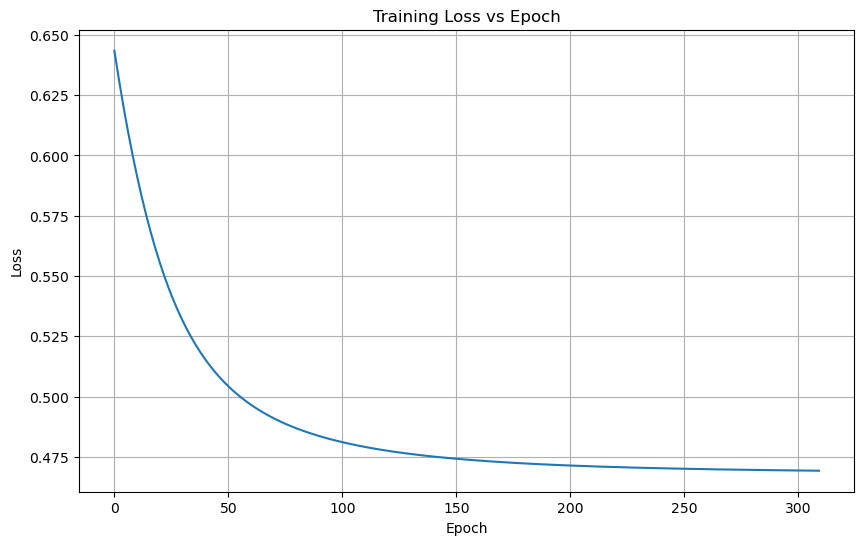

In [60]:

def main():
    try:
        regression_data = pd.read_csv(file_path)
        if regression_data.isnull().values.any():
            print("Warning: Dataset contains missing values")
            regression_data = regression_data.dropna()

        X, y = load_data(regression_data)

        X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)

        X_train_std, X_val_std, X_test_std = standardize_features(X_train, X_val, X_test)


        y_train_median = np.median(y_train)
        y_train = (y_train > y_train_median).astype(int)
        y_val_median = np.median(y_val)
        y_val = (y_val > y_val_median).astype(int)
        y_test_median = np.median(y_test)
        y_test = (y_test > y_test_median).astype(int)

        X_train_final = np.hstack((X_train_std, np.ones((X_train_std.shape[0], 1))))
        X_val_final = np.hstack((X_val_std, np.ones((X_val_std.shape[0], 1))))
        X_test_final = np.hstack((X_test_std, np.ones((X_test_std.shape[0], 1))))

        learning_rates = [0.1, 0.01, 0.001, 0.0001]
        max_iter = 500
        results = []

        for lr in learning_rates:
            theta, history = train_model(X_train_final, y_train, lr, max_iter)
            val_acc = evaluate_model(X_val_final, y_val, theta)
            results.append((lr, val_acc))
            print(f"Learning rate: {lr}, Validation accuracy: {val_acc:.2f}%")

        best_lr = max(results, key=lambda x: x[1])[0]
        print(f"\nBest learning rate: {best_lr}")

        final_theta, final_history = train_model(X_train_final, y_train, best_lr, max_iter)
        test_acc = evaluate_model(X_test_final, y_test, final_theta)
        print(f"Test accuracy: {test_acc:.2f}%")

        plt.figure(figsize=(10, 6))
        plt.plot(range(len(final_history)), final_history)
        plt.title('Training Loss vs Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()